## 1. Data preprocessing and export (Maya → JSON)

This project requires exporting the skeleton hierarchy and skinning data from the T-pose file of a character created in Maya + Advanced Skeleton (without facial binding) for subsequent pose reconstruction and scoring/visualization.

Run the following script in the Maya Script Editor (Python) to complete the cleanup and export:
- `Clean_file_from_AdvRigChar.py`: Clean up the skeleton and mesh (remove controllers, copy weights/rename)
- `MayaJointsHierarchyOutput.py`: Export skeleton hierarchy and local binding matrix (including rotation order)至`pose_file_path/maya_default_pose_output`
- `MayaGlobalBindingMatrixOutput.py`: Export the global binding matrix (worldMatrix under Bind Pose) of each joint to`pose_file_path/maya_default_pose_output/weight`
- `MayaJointListInfluenceOutput.py`: Export the list of influencing joints (influences) for each mesh to`pose_file_path/maya_default_pose_output/weight`
- `MayaWeightOutput.py`: Export the vertex weight matrix of each mesh to `pose_file_path/maya_default_pose_output/weight`

The above exported products constitute all the inputs for the subsequent **skeleton reconstruction + linear skinning (LBS)**; where `joints_hierarchy_local.json` provides parent/child relationships and **local binding matrices**, `bind_matrices.json` provides **global (world) binding matrices**, and `influences_*` and `weights_*` provide **joint influence order and weights for each vertex**.

## 2. Load T-pose binding data & prepare linear skinning (LBS)

Here, two core tool modules are called:

(A) `T_poseFromMayaProcess.load_local_bind_and_orient`, reads `joints_hierarchy_local.json`, and parses out:
- `parent_map`: Parent-child relationships (short names) for each joint.
- `sorted_entries`: A list of joints sorted by hierarchical depth (for top-down recursion).
- `local_bind`: The **local binding matrix** $L_j \in \mathbb{R}^{4\times 4}$ for each joint, read in column major order.

For any joint's **global binding matrix** $G^{\mathrm{bind}}_j$, it can be calculated recursively:
    
    $$
    G^{\mathrm{bind}}_j =
    \begin{cases}
    L_j, & \text{if } \mathrm{parent}(j) = \varnothing \\
    G^{\mathrm{bind}}_{\mathrm{parent}(j)} \cdot L_j, & \text{otherwise}
    \end{cases}
    $$
    
    Corresponds to `compute_bind_global(j)` in the code.

(B) `process_pose.skin_character`, taken from the exported files in the `.../weight/` directory:
- `verts_rest_*.json`: **rest pose vertices** $V_{\mathrm{rest}}$ for each mesh.
- `influences_*.json`: **joint lists and order** for each mesh (aligned with the weight columns).
- `weights_*.json`: **per-vertex weights** $W \in \mathbb{R}^{V \times J}$.
- `bind_matrices.json`: **Global binding matrices**, which are inverted during loading to obtain $B_j^{-1}$.

Given the **joint world matrix** $T_j$ for any pose (here, the binding pose $T_j = G^{\mathrm{bind}}_j$ is used for verification visualization),  
    Perform **linear blend skinning** (LBS) on the vertices:
$$
    \tilde{v} =
    \left( \sum_{j=1}^J w_j \, T_j \, B_j^{-1} \right) v_{\mathrm{rest}}(h),
    \quad
    v = \Pi(\tilde{v})
    $$
    where $v_{\mathrm{rest}}(h)$ is the homogeneous coordinate, and $\Pi(\cdot)$ denotes dehomogenization by dividing by the homogeneous component $w$. Implementation details can be found in `skin_mesh/skin_character`.

In [1]:
pose_file_path = "/home/s5722875/Notes/Semester3/AIM_MasterProject_PoseOptimize/"

In [2]:
import T_poseFromMayaProcess as TP
import process_pose as PP

Tpose_json_path = pose_file_path + "maya_default_pose_output/joints_hierarchy_local.json"
parent_map, sorted_entries, local_bind, rotate_order, depth_map = TP.load_local_bind_and_orient(Tpose_json_path)

weight_dir = pose_file_path + "maya_default_pose_output/weight"
Tpose_globals = {j: TP.compute_bind_global(j) for j in local_bind}
_, V_concat, per_vertex_weights = PP.skin_character(weight_dir, Tpose_globals, return_weights=True)

#### Visualization (Skeleton / Skeleton + Skinned Mesh)

`Visualize.plot_skeleton`: Extract translations from each joint world matrix, i.e., joint coordinates, and connect them into a skeleton according to parent_map.

`Visualize.plot_skeleton_and_skin`: Overlay the skeleton and skinned point cloud on the same graph.

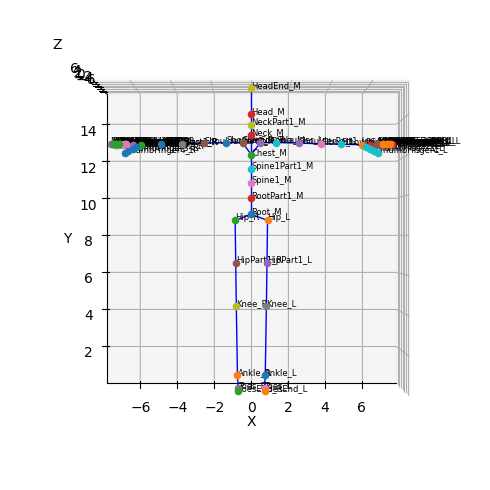

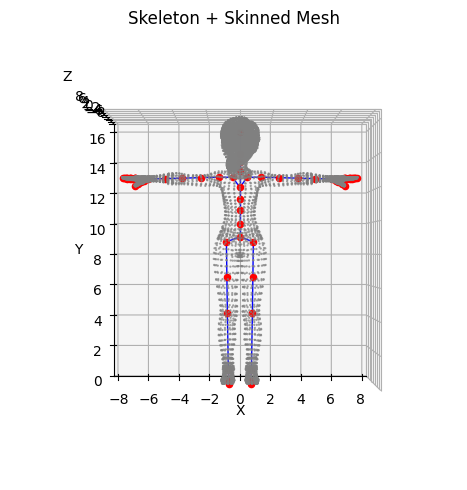

(<Figure size 500x500 with 1 Axes>,
 <Axes3D: title={'center': 'Skeleton + Skinned Mesh'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [3]:
import Visualize
Visualize.plot_skeleton(Tpose_globals, parent_map, figsize=(5,5), elev=90, azim=-90)
Visualize.plot_skeleton_and_skin(joint_global_matrix=Tpose_globals, parent_map=parent_map,
                                     V_concat=V_concat, elev=90, azim=-90, figsize=(5, 5), show_joint_labels=False)

## 3. Pose File Pose and Camera Data Import

First, run the following script in Maya to export the character's pose and camera parameters for the current frame as JSON (can be used for skeletal binding or binding characters with the adv plugin (adv must be cleared first))
- `MayaPoseFileDataOutput.py` → `maya_posefile_output/*.json`: Records the **local rotation** (Joint Rotation, JR) and **translation** of each joint.  
- `MayaPoseFileCamOutput.py` → `*_cam.json`: Records the camera's **internal parameters** (focal length, principal point, etc.) and **external parameters** (pose).

1. Load pose data
- Read `pose_JR_orig` (joint local rotation angles), formatted to align with `sorted_entries / local_bind`, for reconstructing the world matrix.

2. Generate the world matrix (`pose_globals_orig`, call `process_pose.build_pose_globals`)
- Recursively multiply the **local binding matrix** by the **local rotation** to construct the world matrix $G_j$ for each joint starting from the root node $\mathrm{Root}_M$:  
    
    $$
    G_j =
    \begin{cases}
    L^{\mathrm{bind}}_j \cdot R_j(\mathrm{JR}), & \text{if } \mathrm{parent}(j) = \varnothing \\
    G_{\mathrm{parent}(j)} \cdot L^{\mathrm{bind}}_j \cdot R_j(\mathrm{JR}), & \text{otherwise}
    \end{cases}
    $$
    
    where \(R_j(\mathrm{JR})\) is the Euler rotation matrix based on the rotation order.  

3. Load camera parameters (call `process_pose.compute_camera_from_json`)
- **Internal parameter matrix** \(K\) (pixel units):
  
    $$
    K =
    \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
    \end{bmatrix}
    $$
    
    where $f_x, f_y$ are the horizontal/vertical focal lengths, and $c_x, c_y$ are the principal point coordinates.  

- **External parameter matrix** $M_{\mathrm{cam} \to \mathrm{world}}$ (4×4): Describes the position and orientation of the camera in the world coordinate system.  


**Function**: Converts joint local rotations exported from Maya back into skeleton poses that can be drawn/scored in the world coordinate system, along with camera parameters, for subsequent projection, LoA fitting, and visualization.

In [4]:
import json
import process_pose as PP

pose_json_path = pose_file_path + "maya_posefile_output/G2_stand_bad_front.json"
with open(pose_json_path, 'r') as f:
    pose_JR_orig = json.load(f)
# Maya pose processed as pose_globals_orig
pose_globals_orig = PP.build_pose_globals(sorted_entries, local_bind, parent_map, pose_JR_orig, root_name="Root_M")

# pose file cam internal and external parameters
cam_json_path = pose_file_path + "maya_posefile_output/G2_Front_ForBad_cam.json"
K, M_cam_to_world = PP.compute_camera_from_json(cam_json_path, image_width = 960, image_height = 540)

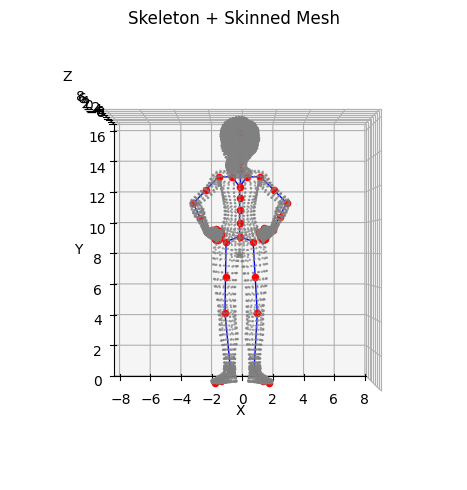

(<Figure size 500x500 with 1 Axes>,
 <Axes3D: title={'center': 'Skeleton + Skinned Mesh'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [5]:
import process_pose as PP

V_all_dict, V_concat = PP.skin_character(weight_dir, pose_globals_orig)
Visualize.plot_skeleton_and_skin(joint_global_matrix=pose_globals_orig,
    parent_map=parent_map,V_concat=V_concat,figsize=(5, 5),elev=90, azim=-90,show_joint_labels=False)

## 4. LoA (Line of Action) Extraction and Idealization

Project 3D poses onto 2D joints, automatically extract LoA point sets, fit **cubic Bézier motion lines**, and obtain more expressive ideal LoA through “**viewpoint correction + control point pushing**”, while returning the fine-tuned `pose_JR` for subsequent optimization.

1. Projection to 2D: `project_pose_to_2d`
- Transform each joint's world coordinate $X_w$ to the camera coordinate system:  $X_c = R^\top (X_w - t)$, considering the Maya camera orientation $(+Z → -Z)$ after perspective projection, and multiply by the intrinsic matrix $K$ to obtain the pixel coordinates $(u,v)$. Filter out points behind the camera $(z \le 0)$.

2. LoA candidate extraction: `extract_loa_candidates`
- Assemble the trunk sequence (Head → Neck → Chest → Spine → Root) and use the lower trunk to estimate the trend vector \(T\).  
- Compare the angles between the left and right legs (Hip–Knee, Knee–Ankle) and \(T\):
- If the angle is less than `align_max_deg` (default 35°), it is considered to be in the same direction as the trunk.
- Use `knee_straight_min_deg` (default 135°) to determine if the leg is straight, and decide whether to include the Ankle.  
- Output `selected_loa` (including joint names and pixel coordinates).

3. Cubic Bézier fitting: `fit_cubic_bezier`
- Fix the start and end points as $P_0, P_3$, and obtain $t_i$ by parameterizing the chord length. Establish a least squares equation for $P_1, P_2$:
$$
B(t) = (1-t)^3 P_0 + 3(1-t)^2 t P_1 + 3(1-t) t^2 P_2 + t^3 P_3, \quad\begin{bmatrix}b_1(t_i) & b_2(t_i)\end{bmatrix}
$$

- Solve for $P_1, P_2$ and the list of $t$. 

4. Ideal LoA search: `get_ideal_bezier(...)`, (three steps)
1. **Original curve straightness check**: Calculate the curvature and determine whether it is C-shaped or S-shaped. If the threshold is met, return directly.  
2. **View angle correction**: Perform a yaw angle search on `Root_M` along the world **Y-axis**, reconstructing `pose_globals → 2D → LoA → Bézier` each time, and select the one with the optimal curvature.  
3. **Control point pushing**: Push $P_1, P_2$ along the normal direction of $P_0 \to P_3$ until the curvature meets the criteria or the step size limit is reached. If LoA touches the leg, perform **Root contour level translation** (keep $v$ unchanged, align $u$ to the Bézier contour point), and reverse the displacement from pixels to world coordinates and write it back to `root_pos`.  

In [6]:
import importlib
import LoA_optimize as LOAO
importlib.reload(LOAO)

points_2d = LOAO.project_pose_to_2d(pose_globals_orig, K, M_cam_to_world)
_, selected_loa = LOAO.extract_loa_candidates(points_2d, align_max_deg=35, knee_straight_min_deg=135)
control_points, _ = LOAO.fit_cubic_bezier(selected_loa)
best_ctrl, fixed_p2d, fixed_loa, LoAfix_poseJR = LOAO.get_ideal_bezier(control_points, points_2d, selected_loa, pose_JR_orig,
                                                                  sorted_entries, local_bind, parent_map, K, M_cam_to_world,
                                                                    push_policy='auto')

[Init] S-shape, bend=36.6°, TH=55°
⚠️  Space remediation failed, start pushing P1/P2 …
✅  Push Success: bend=46.8° (s=50px)


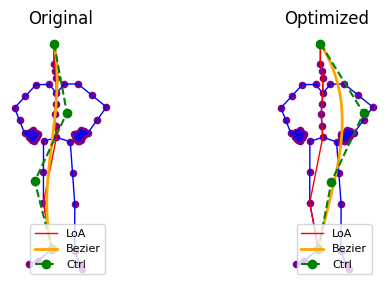

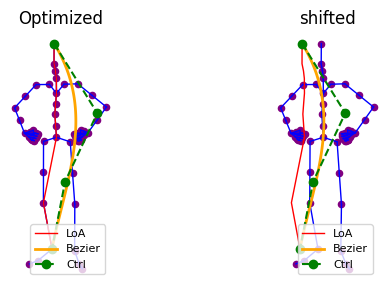

In [7]:
LOAO.visualize_loa_pair(parent_map,
                        # before
                        points_2d, selected_loa, control_points,
                        # after
                        fixed_p2d, fixed_loa, best_ctrl,
                        titles=('Original', 'Optimized'))
pose_globals_LOAO = PP.build_pose_globals(sorted_entries, local_bind, parent_map, LoAfix_poseJR, 'Root_M')
points_2d_1 = LOAO.project_pose_to_2d(pose_globals_LOAO, K, M_cam_to_world)
LOAO.visualize_loa_pair(parent_map,
                        # before
                        fixed_p2d, fixed_loa, best_ctrl,
                        # after
                        points_2d_1, fixed_loa, best_ctrl,
                        titles=('Optimized', 'shifted'))

## 5. Scoring Module and Multi-stage Genetic Algorithm Optimization

In this stage, the **scoring function** and **joint rotation search space** are defined in stages and optimized sequentially using a genetic algorithm (GA) at each stage, ultimately superimposed to form the globally optimal posture.

### 5.1 One-time preprocessing (role-level)

`precompute_segment_r_world_from_weights`: Estimates the maximum radius of each body segment in world coordinates (optional conical scaling) based on the skinning weights and point cloud of the **T-pose**.  
- Parameters:  
  - **quantile**: Controls the quantile to enhance robustness against outliers.  
  - **safety**: Safety factor (amplifies the radius).  
  - **weight_thr**: Threshold for filtering joint weights with weak influence.  
- Output:
- `radii_world`: Geometric reference for subsequent **2D/3D collision detection** and **silhouette** calculation.

`detect_hand_contacts_AB`: Detects the contact state between the **hands** and the **torso/arms**.  
- Output:
  - Anchor set (hand contact anchors) for hand contact penalties in **Stage E**.

`detect_grounded_feet_from_orig`: Detects the initial landing foot and ground height `ground_y` based on the **T-pose** position.
- Purpose:  
  - Used for **ground penetration penalties** in subsequent stages.

In [8]:
import score

radii_world = score.precompute_segment_r_world_from_weights(Tpose_globals, V_concat, per_vertex_weights,
                            quantile=0.80, safety=1.10, weight_thr=0.30, use_cone=True) # T-pose radius
hand_anchors = score.detect_hand_contacts_AB(pose_globals_LOAO,radii_world,band_mm=0.3) # Adhere to the determined bandwidth
grounded_map, ground_y = score.detect_grounded_feet_from_orig(Tpose_globals,ground_y=None,eps=0.02) # Ground tolerance

### 5.2 Joint Rotation Range Definition (by Stage)

`OPT_JOINTS`: List of optimizable joints, with each joint corresponding to three rotation axes (X/Y/Z).  

`make_ranges`: Specifies the rotation range `(min_deg, max_deg)` for each joint set.  

| Stage | Optimizable Joint Range | Primary Purpose |
|------|----------------|----------|
| **Stage A** | Full body joint mobility (knees rotate only around the Z axis) | Used for **LoA optimization** |
| **Stage B** | Only head joints are movable | Optimizes **camera orientation** |
| **Stage C** | Arm position recovery (maintains LoA form unchanged) | Fine-tune arm position |
| **Stage D** | Leg and lower limb adjustment | Optimize **silhouette + ground contact** |
| **Stage E** | Left and right hand and arm refinement | Optimize **silhouette + contact relationships** |

In [9]:
OPT_JOINTS = ['Hip_L','Hip_R','RootPart1_M','Spine1_M','Knee_L','Knee_R','Spine1Part1_M','Ankle_L','Ankle_R',
              'Chest_M','Neck_M','Shoulder_L','Shoulder_R','NeckPart1_M','Head_M','Elbow_L','Elbow_R','Wrist_L','Wrist_R']

Larms_only  = {'Shoulder_L','Wrist_L'}
Rarms_only  = {'Shoulder_R','Wrist_R'}
legs_only   = {'Hip_L','Hip_R','Ankle_L','Ankle_R'}
Z_ONLY_leg  = {'Knee_L','Knee_R'}
Z_ONLY_arm  = {'Elbow_L','Elbow_R'}

def make_ranges(overrides, default=(0,0)):
    """overrides: list of (joint_set, [(x1,x2),(y1,y2),(z1,z2)])"""
    pr = []
    for jn in OPT_JOINTS:
        for js, rng in overrides:
            if jn in js:
                pr += rng
                break
        else:
            pr += [default, default, default]
    return pr

stageA_param_ranges = lambda: make_ranges([
    (Larms_only | Rarms_only | Z_ONLY_arm, [(0,0),(0,0),(0,0)]),
    (Z_ONLY_leg,  [(0,0),(0,0),(-10,10)]),
    (set(OPT_JOINTS), [(-30,30),(-30,30),(-30,30)])
])

stageB_param_ranges = lambda: make_ranges([
    ({'Head_M'}, [(-45,45),(-45,45),(-45,45)])
])

stageC_param_ranges = lambda: make_ranges([
    (Larms_only | Rarms_only, [(-45,45),(-45,45),(-45,45)]),
    (Z_ONLY_arm, [(0,0),(0,0),(-45,45)])
])

stageD_param_ranges = lambda: make_ranges([
    (Z_ONLY_leg, [(0,0),(0,0),(-15,90)]),
    (legs_only,  [(-90,90),(-90,90),(-90,90)])
])

stageE_param_ranges = stageC_param_ranges  # E and C are the same

joint_idx_map = {jn: i*3 for i, jn in enumerate(OPT_JOINTS)}


### 5.3 Scoring function `evaluate_pose`

The input is a rotation increment vector (length = `len(OPT_JOINTS) × 3`), and the fitness `fitness` is output after combining the reference pose by stage:

1. Apply rotation increments
- Overlay the XYZ Euler angle increments of each joint onto `LoAfix_poseJR` to construct a new `pose_globals`.

2. Calculation methods and meanings of various scoring/penalty functions called in `score.py`

- `line_of_action_score(selected_loa, best_ctrl)`: Make the LoA joint point sequence more closely fit the fitted cubic Bézier curve. Method: Sample the Bézier curve, calculate the mean square distance from the LoA point to the curve, and map it to (0,1].
  - Sample curve point $B(t)$, take the square of the distance $d_i^2$ between each LoA point $p_i$ and the nearest sampled point;
$$S_{\text{fit}}=\frac{1}{1+\lambda_{\text{fit}}\,E_{\text{fit}}}\in(0,1]$$
  - Return $(S_{\text{fit}}, E_{\text{fit}}, \sqrt{d_i^2})$. When `agg_roothip=True`, the left and right hips are aggregated with the root for noise reduction and stability.

- `camera_facing_score(pose_globals, M_cam_to_world, joint_name="Head_M")`: Makes the specified joint (default head) face the camera.
  - Take the world pose $T_{\text{head}}$ of the head and the world pose $T_{\text{cam}}$ of the camera, and calculate the cosine of the angle between the unit vector $\hat{v}{\to \mathrm{cam}}$ (from the head to the camera) and the head orientation vector $\hat{v}{\text{head}}$:
$$S_{\text{cam}}=\mathrm{clamp}_{[0,1]}(\cos\theta).$$
The score is $\cos\theta$ clamped to $[0,1]$, with 1 for fully facing ( $\theta=0^\circ$ ) and 0 for facing away ( $\theta\ge 90^\circ$ ).

- Rigid alignment penalty `rigid_penalty_global_v2`: Constrains the positions/orientations of several key joints relative to the reference pose (original or previous stage result) from deviating too much.
  - Single joint cost:
$$w_t\,\|\mathbf{t}_{\text{now}}-\mathbf{t}_{\text{ref}}\|_2 + w_r\,\angle(R_{\text{now}},R_{\text{ref}}),$$
where the rotation error is the geometric angle $\angle(\cdot)$; the sum of multi-joint values is returned with a **negative sign** as the penalty value (the more negative, the worse). Optionally, apply a light anchor point to stabilize the foot.

- Runtime radius and 2D capsule `capsule_r_px_runtime` / `build_capsules_px`: Convert the world radius of body segments obtained by weighting statistics in T-pose to pixel radius, and construct a 2D capsule of “line segment + radius” on the image plane to evaluate the silhouette distance.
  - World radius $;r_{\text{world}}\to$ pixel radius:
$$r_{px} = z_{\mathrm{cam}} \, f_x \, r_{\mathrm{world}}$$
The cone radius is taken as the larger value of the two end projections as a precaution. Then, assemble the 2D capsule using the endpoints $(u,v)$ and $r_{\text{px}}$.

- Silhouette term `silhouette_score`: Maintain a clear gap between key limbs and the torso in 2D, and try to maintain the LoA direction (`keep_ctrl`).
  - Minimum separation: Calculate the “minimum boundary distance” between two capsules (or point–capsules): $\mathrm{minsep} = d_{\mathrm{seg/pt}} - (r_A + r_B)$
- Map the minimum distance to a reward in the range $[-\text{overlap},1]$:
$$\begin{cases} \mathrm{minsep}/\text{target}, & \mathrm{minsep}\ge 0\\[2pt] \max(-\text{overlap},\,\mathrm{minsep}/(-\text{target})), & \mathrm{minsep}<0 \end{cases}$$
- Combination term (weighted by weight):
    - Torso–leg (only count the side without LoA, prioritize moving the leg that does not carry LoA)
- Torso–arm, leg–leg, arm–arm, arm–leg
    - LoA keep term: perform `line_of_action_score` again with `keep_ctrl` and the current LoA
$$w_{\text{leg\_torso}}\,\mathrm{reward}+\cdots+w_{\text{keep}}\,S_{\text{fit}}^{(\text{keep})}.$$
Weights and target seam width (pixels) are configurable; smaller for distant scenes, larger for close-up scenes.

- 3D self-collision penalty `collision_penalty_capsule3d`: Approximate capsules using line segments + radius in the 3D world to suppress key parts from intersecting.
  - Calculate the shortest 3D line segment distance $d_{\text{3D}}$ for a pair of segments $(A,B)$, and compare it with the capsule radii: $\mathrm{sep}_{3\mathrm{D}} = d_{3\mathrm{D}} - (r_A + r_B)$
  - If $\mathrm{sep}_{3\text{D}}<0$, apply a positive penalty and normalize by `tgt_mm`; sum over the top-k worst cases to suppress noise. Higher values indicate worse performance.

- Ground penalty `ground_penalty`: For feet marked as “should be on the ground,” avoid passing through the ground and maintain a reasonable foot orientation.
  - Ground penetration: If the toe/sole $y<y_{\text{ground}}$, deduct points linearly based on depth;  
  - Orientation: If $\angle(\overrightarrow{\text{Ankle}\to\text{Toe}}, ,+Y)$ exceeds the threshold (default $25^\circ$), deduct points.

- Hand contact penalty/maintenance `detect_hand_contacts_AB` & `hand_contact_penalty`: Automatically detect hand contact anchor points from the previous A+B phase (e.g., wrist touching the torso/thigh/calf), and encourage “contact with the surface or slight separation” in the E phase to avoid penetration or excessive separation.
  - Detection: Calculate the separation between the wrist and the target segment in the AB pose as $\mathrm{sep}_{3\text{D}}=d-r(\cdot)$. If it falls within $[-b,+b]$, it is considered a contact anchor point;
  - Stage E penalty: For anchor points, the expected range is $0\le \mathrm{sep}_{3\text{D}}\le b$. Outside this range, penalties are applied linearly based on the deviation amount/bandwidth (heavy penalties for overlapping, light penalties for being too far away `soft`).

3.Stage scoring parameters

- Stage A (LoA) $f = \mathrm{LoA\_score}(\text{selected\_loa}, \text{best\_ctrl})$
- Stage B (camera orientation + rigid constraints) $f = 1.0 \times S_{\mathrm{cam\_head}} + 0.2 \times P_{\mathrm{rigid}}$
- Stage C (Hand Position Constraint) $f = P_{\mathrm{rigid}}(\mathrm{Wrist\_L}, \mathrm{Wrist\_R})$
- Stage D (silhouette + collision + ground + rigid constraints) $f = 1.0 \times S_{\mathrm{sil}} - 0.25 \times P_{\mathrm{coll3d}} - 0.40 \times P_{\mathrm{ground}} + 0.10 \times P_{\mathrm{rigid}}$
- Stage E (silhouette + collision + hand contact) $f = 1.0 \times S_{\mathrm{sil}} - 0.20 \times P_{\mathrm{coll3d}} - 0.60 \times P_{\mathrm{hand\_contact}}$

In [33]:
import score
import copy
import numpy as np

def ranges_to_mask(param_ranges):
    # 0/1 mask: Set positions in the range (0,0) to 0.
    m = []
    for lo, hi in param_ranges:
        m.append(0.0 if (lo == 0 and hi == 0) else 1.0)
    return np.array(m, dtype=float)

def evaluate_pose(vector, stage='A', joint_order=OPT_JOINTS, base_vec=None, base_mask=None, param_ranges=None):  

    # —— Combination vector: base_vec + mask * vector ——
    vec = np.array(vector, dtype=float)
    if base_vec is None:
        composed = vec
    else:
        if base_mask is None:
            base_mask = np.ones_like(vec)
        composed = np.array(base_vec, float) + np.array(base_mask, float) * vec
        
    # 1) Deep copy posture, with optional root translation
    pose_JR = copy.deepcopy(LoAfix_poseJR)

    # 2) Superimpose the rotation increments of each joint
    for jn in joint_order:
        idx = joint_idx_map[jn]
        dx, dy, dz = composed[idx:idx+3]
        ox, oy, oz = pose_JR["joint_rot"][jn]
        pose_JR["joint_rot"][jn] = [ox+dx, oy+dy, oz+dz]

    # 3) Build global & loa preparation
    pose_globals = PP.build_pose_globals(sorted_entries, local_bind, parent_map, pose_JR, 'Root_M')
    points_2d    = LOAO.project_pose_to_2d(pose_globals, K, M_cam_to_world) #计算loa评分
    _, selected_loa = LOAO.extract_loa_candidates(points_2d, align_max_deg=35, knee_straight_min_deg=135)

    # 4) Stage-specific scoring
    if stage == 'A':
        loa_sc, _, _ = score.line_of_action_score(selected_loa, best_ctrl)  # LoA
        fitness = (1.0 * loa_sc)
        return (float(fitness),)

    elif stage == 'B':
        cam_head = score.camera_facing_score(pose_globals, M_cam_to_world, joint_name="Head_M")
        const_head = score.rigid_penalty_global_v2(pose_globals, pose_globals_orig,
                                        constraints={'HeadEnd_M':  dict(w_t=0.005, w_r=0),},use_toe_anchor=True)   # 位置旋转约束
        fitness = (1.0 * cam_head + 0.2 * const_head)
        return (float(fitness),)

    elif stage == 'C':
        const = score.rigid_penalty_global_v2(pose_globals, pose_globals_LOAO, constraints={
                                            'Wrist_L': dict(w_t=1, w_r=0.2),'Wrist_R': dict(w_t=1, w_r=0.2),},
                                             use_toe_anchor=False)   # 位置旋转约束
        fitness = (1.0 * const)
        return (float(fitness),)

    elif stage == 'D':
        r_px_by_seg = score.capsule_r_px_runtime(pose_globals, K, M_cam_to_world, radii_world) # 运行时半径
        sc_sil, sil_terms, sil_argmins, move_leg = score.silhouette_score(points_2d, r_px_by_seg,
                                                    keep_ctrl=best_ctrl, selected_loa=selected_loa,
                                                    target_gap_px=10, w_leg_torso=0.7, w_elbow_torso=0.0, w_keep=0.0,
                                                     w_arm_torso=0.0, w_leg_leg=0.10, w_arm_arm=0.0, w_arm_leg=0.0)
        coll3d = score.collision_penalty_capsule3d(pose_globals, radii_world, topk=4, tgt_mm=0.1)
        gpen   = score.ground_penalty(pose_globals, grounded_map, ground_y, up_vec_thresh_deg=25.0)
        const = score.rigid_penalty_global_v2(pose_globals, pose_globals_LOAO, constraints={
                                            'Ankle_L': dict(w_t=0.2, w_r=0.2),'Ankle_R': dict(w_t=0.2, w_r=0.2),},
                                            use_toe_anchor=False)   # 位置旋转约束
        fitness = (1.00 * sc_sil - 0.05 * coll3d - 0.40 * gpen + 0.10 * const)
        return (float(fitness),)

    elif stage == 'E':
        r_px_by_seg = score.capsule_r_px_runtime(pose_globals, K, M_cam_to_world, radii_world) # 运行时半径
        sc_sil, sil_terms, sil_argmins, move_leg = score.silhouette_score(points_2d, r_px_by_seg,
                                                    keep_ctrl=best_ctrl, selected_loa=selected_loa,
                                                    target_gap_px=5, w_leg_torso=0.0, w_elbow_torso=0.0, w_keep=0.0,
                                                     w_arm_torso=0.2, w_leg_leg=0.0, w_arm_arm=0.2, w_arm_leg=0.15)
        coll3d = score.collision_penalty_capsule3d(pose_globals, radii_world, topk=4, tgt_mm=0.1)
        hpen = score.hand_contact_penalty(pose_globals, radii_world, hand_anchors, band_mm=0.3, soft=1.0)
        fitness = (1.00 * sc_sil - 0.20 * coll3d - 0.60 * hpen )
        return (float(fitness),)

### 5.4 Multi-stage GA optimization process
- Optimizer: `Model.optimize_pose_GA` (based on the DEAP framework)
- Population size: `mu` / `lambda_`, Gaussian mutation: `mutGaussian(sigma)`, Crossover: `cxBlend`
  - Supports stage-based **parameter freezing mask** `mask` and seed vector `seed_vec`


- Execution order
$$base\_ABCDE = A + B + C + D + E$$

Avoid slow convergence and conflicts caused by a single global search, ensuring the optimization sequence aligns with animators' work habits: LoA → Camera → Arms → Legs → Refinement

In [34]:
import Model
importlib.reload(Model)

# —— Stage A loa ——
prA = stageA_param_ranges()
fnA = lambda v: evaluate_pose(v, stage='A', param_ranges=prA)
bestA = Model.optimize_pose_GA(fnA, prA, ngen=20, mu=30, lambda_=60, sigma=5.0, seed_vec=None)

# —— Stage B Cam Facing ——
prB = stageB_param_ranges()
maskB = ranges_to_mask(prB)
fnB = lambda v: evaluate_pose(v, stage='B', base_vec=bestA, base_mask=maskB, param_ranges=prB)
bestB = Model.optimize_pose_GA(fnB, prB, ngen=20, mu=30, lambda_=60, mutpb=0.4, sigma=5.0, seed_vec=np.zeros(len(prB)), seed_spread=1.0)

# —— Stage C adjust arm ——
base_AB = np.array(bestA) + maskB * np.array(bestB)
prC = stageC_param_ranges()
maskC = ranges_to_mask(prC)
fnC = lambda v: evaluate_pose(v, stage='C', base_vec=base_AB, base_mask=maskC, param_ranges=prC)
bestC = Model.optimize_pose_GA(fnC, prC, ngen=30, mu=45, lambda_=80, sigma=5.0, mutpb=0.4,seed_vec=np.zeros(len(prC)), seed_spread=1.5)

# —— Stage D leg silhouette ——
base_ABC = np.array(base_AB) + maskC * np.array(bestC)
prD = stageD_param_ranges()
maskD = ranges_to_mask(prD)
fnD = lambda v: evaluate_pose(v, stage='D', base_vec=base_ABC, base_mask=maskD, param_ranges=prD)
bestD = Model.optimize_pose_GA(fnD, prD, ngen=20, mu=30, lambda_=60, mutpb=0.4, sigma=4.0, seed_vec=np.zeros(len(prD)), seed_spread=0.8)

# —— Stage E hand silhouette ——
base_ABCD = np.array(base_ABC) + maskD * np.array(bestD)
prE = stageE_param_ranges()
maskE = ranges_to_mask(prE)
fnE = lambda v: evaluate_pose(v, stage='E', base_vec=base_ABCD, base_mask=maskE, param_ranges=prE)
bestE = Model.optimize_pose_GA(fnE, prE, ngen=20, mu=30, lambda_=60, sigma=3.0, seed_vec=np.zeros(len(prE)), seed_spread=0.8)

base_ABCDE = np.array(base_ABCD) + maskE * np.array(bestE)

## 6. Apply optimization results and send back to Maya
- `apply_offset`: Overlay the optimized vectors on the reference pose `LoAfix_poseJR` joint by joint to generate the refined pose `pose_JR_refined`, which can be saved as JSON (for use in Maya).

- **Visualization**: Use `build_pose_globals` to reconstruct the global matrix, then use `plot_skeleton` to plot it; this can be called after each stage to view the results.

- **Back to Maya**: Run `RefinedPoseBackToMaya.py` in Maya, read the JSON, and set the root node pose and joint `.rotateX/Y/Z` roles to switch to the optimized pose.

saved: /home/s5722875/Notes/Semester3/AIM_MasterProject_PoseOptimize/refined_pose.json


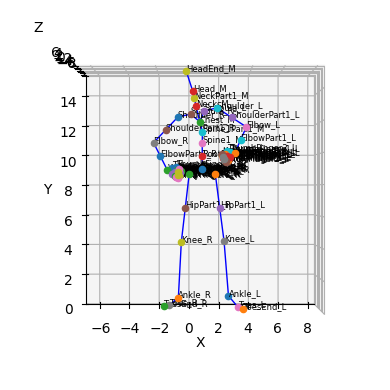

In [35]:
import Visualize

pose_JR_refined = PP.apply_offset(base_ABC, LoAfix_poseJR, OPT_JOINTS, joint_idx_map, outfile= pose_file_path+"refined_pose.json")

# 2) Re-run build_pose_globals on that refined dict
refined_pose_globals = PP.build_pose_globals(sorted_entries,local_bind,parent_map,pose_JR_refined,root_name="Root_M")
# 3) Visualize
Visualize.plot_skeleton(refined_pose_globals, parent_map,figsize=(4,4), elev=90, azim=-90)

saved: /home/s5722875/Notes/Semester3/AIM_MasterProject_PoseOptimize/refined_pose.json


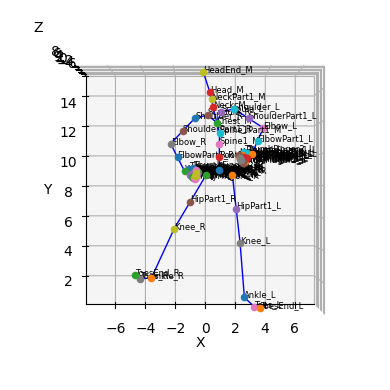

In [36]:
import Visualize

pose_JR_refined = PP.apply_offset(base_ABCD, LoAfix_poseJR, OPT_JOINTS, joint_idx_map, outfile= pose_file_path+"refined_pose.json")

# 2) Re-run build_pose_globals on that refined dict
refined_pose_globals = PP.build_pose_globals(sorted_entries,local_bind,parent_map,pose_JR_refined,root_name="Root_M")
# 3) Visualize
Visualize.plot_skeleton(refined_pose_globals, parent_map,figsize=(4,4), elev=90, azim=-90)

saved: /home/s5722875/Notes/Semester3/AIM_MasterProject_PoseOptimize/refined_pose.json


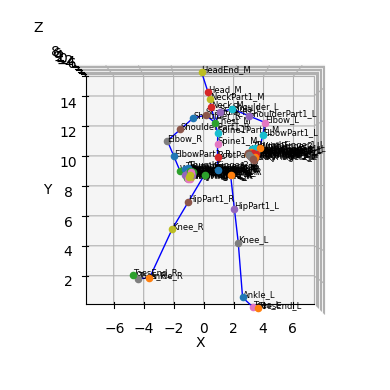

In [37]:
import Visualize

pose_JR_refined = PP.apply_offset(base_ABCDE, LoAfix_poseJR, OPT_JOINTS, joint_idx_map, outfile= pose_file_path+"refined_pose.json")

# 2) Re-run build_pose_globals on that refined dict
refined_pose_globals = PP.build_pose_globals(sorted_entries,local_bind,parent_map,pose_JR_refined,root_name="Root_M")
# 3) Visualize
Visualize.plot_skeleton(refined_pose_globals, parent_map,figsize=(4,4), elev=90, azim=-90)

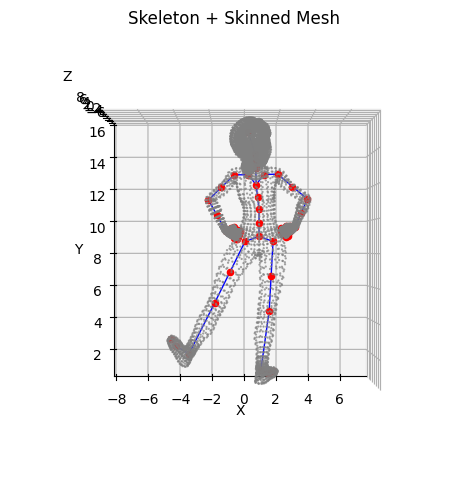

(<Figure size 500x500 with 1 Axes>,
 <Axes3D: title={'center': 'Skeleton + Skinned Mesh'}, xlabel='X', ylabel='Y', zlabel='Z'>)

In [15]:
import process_pose as PP
importlib.reload(PP)

V_all_dict, V_concat = PP.skin_character(weight_dir, refined_pose_globals)
Visualize.plot_skeleton_and_skin(joint_global_matrix=refined_pose_globals,
    parent_map=parent_map,V_concat=V_concat,figsize=(5, 5),elev=90, azim=-90,show_joint_labels=False)